# Setting Up
If data is **not** downloaded as CSVs, run `!pip install --quiet git+https://github.com/songlab-cal/gpn.git`. For getting the data, pick "Option 1: Hugging Face".

In [27]:
# !pip install --quiet git+https://github.com/songlab-cal/gpn.git

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

import torch
import torch.nn as nn
from torch.nn import Embedding
import torch.nn.functional as F
import random

from transformers import PreTrainedTokenizerFast
from tokenizers import Tokenizer, models, normalizers
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
import gffpandas.gffpandas as gffpd

import bioframe as bf
import more_itertools

from Bio import SeqIO, bgzf
from Bio.Seq import Seq
import bioframe as bf
import gzip
from joblib import Parallel, delayed
import multiprocessing as mp
import numpy as np
import pandas as pd
import pyBigWig
from tqdm import tqdm

tqdm.pandas()
import zarr

# Getting the Data (Option 1: Hugging Face)

Skip to the next section if data is already downloaded as CSVs.

**Note**: this section will take 5+ minutes to run.

In [29]:
# from datasets import load_dataset
# from google.colab import files

In [30]:
# # Load data seperately
# train_dataset = load_dataset("songlab/genomes-brassicales-balanced-v1", split="train")
# valid_dataset = load_dataset("songlab/genomes-brassicales-balanced-v1", split="validation")
# test_dataset  = load_dataset("songlab/genomes-brassicales-balanced-v1", split="test")

# # Convert data to DataFrame
# all_train = pd.DataFrame(train_dataset)
# valid = pd.DataFrame(valid_dataset)
# test = pd.DataFrame(test_dataset)

# # Find most common chromosome
# most_common_chrom = all_train.chrom.value_counts(normalize=True).sort_values(ascending=False).index[0]

# # Filter data by most common chromosome
# train = all_train[all_train.chrom == most_common_chrom].reset_index(drop=True)

#### Download data as CSV (Recommended to avoid loading data from Hugging Face again)

In [31]:
# train.to_csv('train.csv', index=False)
# files.download('train.csv')

# valid.to_csv('valid.csv', index=False)
# files.download('valid.csv')

# test.to_csv('test.csv', index=False)
# files.download('test.csv')

# Getting the Data (Option 2: Downloaded CSV)
Skip to the next section if the section "Getting the Data (Option 1: Hugging Face)" was ran.

**Note**: Before running this section, add downloaded CSVs to "Files" in the left menu bar.

In [32]:
train = pd.read_csv('train.csv')[:500]
valid = pd.read_csv('valid.csv')[:500]
test = pd.read_csv('test.csv')[:500]

# Output train data
train.head()

,assembly,chrom,start,end,strand,seq
0,GCF_000309985.2,NC_024803.2,44350126,44350638,-,AACGTTACACAAACCCAAACAAGAAAATACATCAAAAGTCACCCTA...
1,GCF_000801105.1,NW_017353143.1,6209626,6210138,+,CATCTTGAGCTTCCTCGAAAACAATCTGCTCTGTCTCTACATCATT...
2,GCF_000801105.1,NW_017353146.1,2729759,2730271,-,tacagataCAACCATCCTTGGAATGTATCATTCCACATTATACCAT...
3,GCF_000463585.1,NW_010966372.1,1523140,1523652,+,Agggaaaaatatatgaaaatttctgaatttgtaatttggtataata...
4,GCF_000001735.4,NC_003071.7,18874538,18875050,+,GGAATGTACTAATAAACTAGAAAAGATCTTGGGTCTGACTAATGCA...


In [33]:
DEFINED_SYMBOLS = np.frombuffer("ACGTacgt".encode("ascii"), dtype="S1")
UNMASKED_SYMBOLS = np.frombuffer("ACGT".encode("ascii"), dtype="S1")


def load_fasta(path, subset_chroms=None):
    with gzip.open(path, "rt") if path.endswith(".gz") else open(path) as handle:
        genome = pd.Series(
            {
                rec.id: str(rec.seq)
                for rec in SeqIO.parse(handle, "fasta")
                if subset_chroms is None or rec.id in subset_chroms
            }
        )
    return genome


def save_fasta(path, genome):
    with bgzf.BgzfWriter(path, "wb") if path.endswith(".gz") else open(
        path, "w"
    ) as handle:
        SeqIO.write(genome.values(), handle, "fasta")


# Some standard formats
def load_table(path):
    if path.endswith(".parquet"):
        df = pd.read_parquet(path)
    elif "csv" in path:
        df = pd.read_csv(path)
    elif "tsv" in path:
        df = pd.read_csv(path, sep="\t")
    elif "vcf" in path:
        df = pd.read_csv(
            path,
            sep="\t",
            header=None,
            comment="#",
            usecols=[0, 1, 3, 4],
            dtype={0: str},
        ).rename(columns={0: "chrom", 1: "pos", 3: "ref", 4: "alt"})
    elif "gtf" in path or "gff" in path:
        df = pd.read_csv(
            path,
            sep="\t",
            header=None,
            comment="#",
            dtype={"chrom": str},
            names=[
                "chrom",
                "source",
                "feature",
                "start",
                "end",
                "score",
                "strand",
                "frame",
                "attribute",
            ],
        )
        df.start -= 1
    df.chrom = df.chrom.astype(str)
    return df


def load_repeatmasker(path):
    df = pd.read_csv(path, sep="\t").rename(
        columns=dict(genoName="chrom", genoStart="start", genoEnd="end")
    )
    df.chrom = df.chrom.astype(str)
    return df


class Genome:
    def __init__(self, path, subset_chroms=None):
        self._genome = load_fasta(path, subset_chroms=subset_chroms)

    def get_seq(self, chrom, start, end, strand="+"):
        seq = self._genome[chrom][start:end]
        if strand == "-":
            seq = str(Seq(seq).reverse_complement())
        return seq

    def get_nuc(self, chrom, pos, strand="+"):
        # pos is assumed to be 1-based as in VCF
        seq = self._genome[chrom][pos - 1]
        if strand == "-":
            seq = str(Seq(seq).reverse_complement())
        return seq

    def filter_chroms(self, chroms):
        self._genome = self._genome[chroms]

    def get_seq_fwd_rev(self, chrom, start, end):
        seq_fwd = self.get_seq(chrom, start, end)
        seq_rev = str(Seq(seq_fwd).reverse_complement())
        return seq_fwd, seq_rev

    def get_all_intervals(self):
        return pd.DataFrame(
            [
                {"chrom": chrom, "start": 0, "end": len(seq)}
                for chrom, seq in self._genome.items()
            ]
        )

    def get_intervals_matching_symbols(self, symbols):
        def get_intervals_matching_symbols_chrom(chrom):
            complete_interval = pd.DataFrame(
                {"chrom": [chrom.name], "start": [0], "end": [len(chrom.seq)]}
            )
            intervals = pd.DataFrame(
                dict(
                    start=np.where(
                        ~np.isin(
                            np.frombuffer(chrom.seq.encode("ascii"), dtype="S1"),
                            symbols,
                        )
                    )[0]
                )
            )
            if len(intervals) > 0:
                intervals["chrom"] = chrom.name
                intervals["end"] = intervals.start + 1
                intervals = bf.merge(intervals).drop(columns="n_intervals")
                return bf.subtract(complete_interval, intervals)
            return complete_interval

        return pd.concat(
            self._genome.rename("seq")
            .to_frame()
            .progress_apply(
                get_intervals_matching_symbols_chrom,
                axis=1,
            )
            .values,
            ignore_index=True,
        )

    def get_defined_intervals(self):
        return self.get_intervals_matching_symbols(DEFINED_SYMBOLS)

    def get_unmasked_intervals(self):
        return self.get_intervals_matching_symbols(UNMASKED_SYMBOLS)


def add_space_every_k(seq, k):
    return " ".join([seq[x : x + k] for x in range(0, len(seq), k)])


def load_dataset_from_file_or_dir(
    path,
    split="test",
    is_file=False,
    **kwargs,
):
    if is_file:
        return Dataset.from_pandas(load_table(path))
    else:
        return load_dataset(path, split=split, **kwargs)


def token_input_id(token, tokenizer, n_prefix=0):
    return tokenizer(token)["input_ids"][n_prefix]


# TODO: maybe call it I or Is, or ivals instead of intervals


def get_annotation_features(annotation, feature):
    annotation_features = annotation[annotation.feature == feature]
    return bf.merge(
        bf.sanitize_bedframe(annotation_features[["chrom", "start", "end"]])
    )


def intersect_intervals(a, b):
    return bf.overlap(a, b, how="inner", return_overlap=True)[
        ["chrom", "overlap_start", "overlap_end"]
    ].rename(columns=dict(overlap_start="start", overlap_end="end"))


def union_intervals(a, b):
    return bf.merge(pd.concat([a, b], ignore_index=True)).drop(columns="n_intervals")


def intervals_size(intervals):
    return (intervals.end - intervals.start).sum()


def add_flank(intervals, flank):
    return bf.merge(bf.expand(intervals, pad=flank)).drop(columns="n_intervals")


def add_jitter(intervals, magnitude, seed=42):
    # After using this function, we recommend intersecting with
    # Genome.get_all_intervals(), to avoid getting out of chromosome bounds
    # or smaller subsets such as Genome.get_defined_intervals()
    rng = np.random.default_rng(seed)
    jitter = rng.integers(-magnitude, magnitude, size=len(intervals), endpoint=True)
    new_intervals = intervals.copy()
    new_intervals.start += jitter
    new_intervals.end += jitter
    return bf.merge(new_intervals)


def filter_length(intervals, min_interval_len):
    return intervals[intervals.end - intervals.start >= min_interval_len]


def filter_defined(intervals, genome, include_flank=None):
    defined = genome.get_defined_intervals()
    if include_flank is not None:
        defined = add_flank(defined, include_flank)
    return intersect_intervals(intervals, defined)


def filter_unmasked(intervals, genome, include_flank=None):
    unmasked = genome.get_unmasked_intervals()
    if include_flank is not None:
        unmasked = add_flank(unmasked, include_flank)
    return intersect_intervals(intervals, unmasked)


def filter_annotation_features(
    intervals,
    annotation,
    feature,
    include_flank=None,
    jitter=None,
):
    annotation_features = get_annotation_features(annotation, feature)
    if include_flank is not None:
        annotation_features = add_flank(annotation_features, include_flank)
    if jitter is not None:
        annotation_features = add_jitter(annotation_features, jitter)
    return intersect_intervals(intervals, annotation_features)


def get_promoters(annotation, upstream_size, downstream_size=0):
    # not exactly getting promoters, just gettting regions upstream of TSS

    def get_promoter(transcript):
        if transcript.strand == "+":
            start, end = (
                transcript.start - upstream_size,
                transcript.start + downstream_size,
            )
        else:
            start, end = (
                transcript.end - downstream_size,
                transcript.end + upstream_size,
            )
        return pd.Series(dict(chrom=transcript.chrom, start=start, end=end))

    transcripts = annotation[annotation.feature.isin(["mRNA", "transcript"])]
    promoters = transcripts.apply(get_promoter, axis=1)
    return bf.merge(promoters).drop(columns="n_intervals")


def get_random_intervals(intervals, size, n, seed=42):
    rng = np.random.default_rng(seed)
    interval_size = (intervals.end - intervals.start).values
    # the number of random intervals that can be generated per interval
    # e.g. if target size is 512, an interval of size 512 can produce 1 interval,
    # and interval of size 513 can produce 2 intervals
    interval_w = 1 + interval_size - size
    interval_p = interval_w / interval_w.sum()
    rand_interval_index = rng.choice(len(intervals), p=interval_p, size=n)

    rand_intervals = []
    for i in range(n):
        interval = intervals.iloc[rand_interval_index[i]]
        start = rng.integers(interval.start, interval.end - size, endpoint=True)
        end = start + size
        rand_intervals.append([interval.chrom, start, end])
    rand_intervals = pd.DataFrame(rand_intervals, columns=["chrom", "start", "end"])
    return bf.merge(rand_intervals).drop(columns="n_intervals")


def get_balanced_intervals(
    defined_intervals, annotation, window_size, promoter_upstream=1000
):
    # there's the issue of pseudogenes though... should be aware
    exons = add_flank(get_annotation_features(annotation, "exon"), window_size // 2)
    print("exons: ", intervals_size(exons) / intervals_size(defined_intervals))
    promoters = add_flank(
        get_promoters(annotation, promoter_upstream), window_size // 2
    )
    print("promoters: ", intervals_size(promoters) / intervals_size(defined_intervals))
    intervals = union_intervals(exons, promoters)
    intervals = intersect_intervals(add_jitter(intervals, 100), defined_intervals)
    # in case they collide with undefined intervals
    intervals = filter_length(intervals, window_size)
    print("intervals: ", intervals_size(intervals) / intervals_size(defined_intervals))
    # maybe add a 0.5 factor
    n_random_intervals = intervals_size(intervals) // window_size
    random_intervals = get_random_intervals(
        defined_intervals, window_size, n_random_intervals
    )
    print(
        "random_intervals: ",
        intervals_size(random_intervals) / intervals_size(defined_intervals),
    )
    intervals = union_intervals(intervals, random_intervals)
    print("intervals: ", intervals_size(intervals) / intervals_size(defined_intervals))
    print((intervals.end - intervals.start).min())
    assert (intervals.end - intervals.start).min() >= window_size
    return intervals


def make_windows(intervals, window_size, step_size, add_rc=False):
    return pd.concat(
        intervals.progress_apply(
            lambda interval: get_interval_windows(
                interval, window_size, step_size, add_rc
            ),
            axis=1,
        ).values,
        ignore_index=True,
    )


def get_interval_windows(interval, window_size, step_size, add_rc):
    windows = pd.DataFrame(
        dict(start=np.arange(interval.start, interval.end - window_size + 1, step_size))
    )
    windows["end"] = windows.start + window_size
    windows["chrom"] = interval.chrom
    windows = windows[["chrom", "start", "end"]]  # just re-ordering
    windows["strand"] = "+"
    if add_rc:
        windows_neg = windows.copy()  # TODO: this should be optional
        windows_neg.strand = "-"
        return pd.concat([windows, windows_neg], ignore_index=True)
    return windows


def get_seq(intervals, genome):
    intervals["seq"] = intervals.progress_apply(
        lambda i: genome.get_seq(i.chrom, i.start, i.end, i.strand),
        axis=1,
    )
    return intervals


class BigWig(object):
    def __init__(self, path):
        self.bw = pyBigWig.open(path)

    def get_features(self, chrom, start, end, strand="+"):
        x = self.bw.values(chrom, start, end, numpy=True)
        if strand == "-":
            x = x[::-1]
        return x


def _get_msa(i, chroms, starts, ends, strands, obj, kwargs):
    return obj.get_msa(chroms[i], starts[i], ends[i], strand=strands[i], **kwargs)


def _get_msa_fwd_rev(i, chroms, starts, ends, obj, kwargs):
    return obj.get_msa_fwd_rev(chroms[i], starts[i], ends[i], **kwargs)


def _run_vep(i, chroms, poss, refs, alts, obj, kwargs):
    return obj.run_vep(chroms[i], poss[i], refs[i], alts[i], **kwargs)


class GenomeMSA(object):
    def __init__(self, path, subset_chroms=None, in_memory=False):
        self.reverse_complementer = ReverseComplementer()
        self.tokenizer = Tokenizer()

        print("Loading MSA...")
        self.f = zarr.open(path, mode="r")
        chroms = self.f.keys()
        if subset_chroms is not None:
            chroms = [chrom for chrom in chroms if chrom in subset_chroms]
        if in_memory:
            self.data = pd.Series({chrom: self.f[chrom][:] for chrom in tqdm(chroms)})
            self.f.close()
        else:
            # pd.Series does not work with h5py/zarr object
            # (attempts to load all data into memory)
            # beware: dict has issues with parallelism in Pytorch
            self.data = {chrom: self.f[chrom] for chrom in chroms}
        print("Loading MSA... Done")

    def get_msa(self, chrom, start, end, strand="+", tokenize=False):
        msa = self.data[chrom][start:end]
        if strand == "-":
            msa = self.reverse_complementer(msa, position_axis=0)
        if tokenize:
            msa = self.tokenizer(msa)
        return msa

    def get_msa_fwd_rev(self, chrom, start, end, tokenize=False):
        msa_fwd = self.get_msa(chrom, start, end)
        msa_rev = self.reverse_complementer(msa_fwd, position_axis=0)
        if tokenize:
            msa_fwd = self.tokenizer(msa_fwd)
            msa_rev = self.tokenizer(msa_rev)
        return msa_fwd, msa_rev

    def get_msa_batch(
        self, chroms, starts, ends, strands, backend=None, n_jobs=None, **kwargs
    ):
        if backend == "multiprocessing":
            with mp.Pool(processes=n_jobs) as pool:
                msa_batch = pool.starmap(
                    _get_msa,
                    [
                        (i, chroms, starts, ends, strands, self, kwargs)
                        for i in range(len(chroms))
                    ],
                )
        elif backend == "joblib":
            msa_batch = Parallel(n_jobs=n_jobs)(
                delayed(_get_msa)(i, chroms, starts, ends, strands, self, kwargs)
                for i in range(len(chroms))
            )
        elif backend is None:
            msa_batch = [
                _get_msa(i, chroms, starts, ends, strands, self, kwargs)
                for i in range(len(chroms))
            ]
        msa_batch = np.array(msa_batch)
        return msa_batch

    def get_msa_batch_fwd_rev(
        self, chroms, starts, ends, backend=None, n_jobs=None, **kwargs
    ):
        if backend == "multiprocessing":
            with mp.Pool(processes=n_jobs) as pool:
                msa_batch_fwd, msa_batch_rev = zip(
                    *pool.starmap(
                        _get_msa_fwd_rev,
                        [
                            (i, chroms, starts, ends, self, kwargs)
                            for i in range(len(chroms))
                        ],
                    )
                )
        elif backend is None:
            msa_batch_fwd, msa_batch_rev = zip(
                *[
                    _get_msa_fwd_rev(i, chroms, starts, ends, self, kwargs)
                    for i in range(len(chroms))
                ]
            )
        msa_batch_fwd = np.array(msa_batch_fwd)
        msa_batch_rev = np.array(msa_batch_rev)
        return msa_batch_fwd, msa_batch_rev

    def run_vep(self, chrom, pos, ref, alt, pseudocounts=1):
        msa = np.char.upper(self.data[chrom][pos - 1])
        assert msa[0] == ref.encode("ascii"), f"{ref=} does not match {msa[0]=}"
        msa = msa[1:]  # exclude target species
        ref_count = (msa == ref.encode("ascii")).sum() + pseudocounts
        alt_count = (msa == alt.encode("ascii")).sum() + pseudocounts
        ref_prob = ref_count / (ref_count + alt_count)
        alt_prob = alt_count / (ref_count + alt_count)
        return np.log(alt_prob) - np.log(ref_prob)

    def run_vep_batch(
        self, chroms, poss, refs, alts, backend=None, n_jobs=None, **kwargs
    ):
        if backend == "multiprocessing":
            with mp.Pool(processes=n_jobs) as pool:
                vep_batch = pool.starmap(
                    _run_vep,
                    [
                        (i, chroms, poss, refs, alts, self, kwargs)
                        for i in range(len(chroms))
                    ],
                )
        elif backend == "joblib":
            vep_batch = Parallel(n_jobs=n_jobs)(
                delayed(_run_vep)(i, chroms, poss, refs, alts, self, kwargs)
                for i in range(len(chroms))
            )
        elif backend is None:
            vep_batch = [
                _run_vep(i, chroms, poss, refs, alts, self, kwargs)
                for i in range(len(chroms))
            ]
        return np.array(vep_batch)


# Utilities for processing DNA sequences represented as np byte arrays, e.g.
# np.array([b'A', b'C', b'G', b'T', b'N'], dtype='|S1')
# with any number of axes (e.g. batch, species, position)


class Tokenizer(object):
    def __init__(self, vocab="-ACGT?"):
        # -: gap/unknown/pad (simple for now, could split in the future)
        # ?: mask
        unk = vocab.index("-")
        self.table = np.full((256,), unk, dtype=np.uint8)
        for i, c in enumerate(vocab):
            self.table[ord(c)] = i
        self.vocab = vocab
        self.mask_token = "?"
        self.pad_token = "-"

    def __call__(self, x):
        return self.table[np.char.upper(x).view(np.uint8)]

    def __len__(self):
        return len(self.vocab)

    def mask_token_id(self):
        return self.vocab.index("?")

    def unk_token_id(self):
        return self.vocab.index("-")

    def pad_token_id(self):
        return self.vocab.index("-")

    def nucleotide_token_id_start(self):
        return self.vocab.index("A")

    def nucleotide_token_id_end(self):
        return self.vocab.index("T") + 1


class ReverseComplementer(object):
    def __init__(self):
        # Define the complement mapping.
        complement_mapping = {
            b"A": b"T",
            b"T": b"A",
            b"C": b"G",
            b"G": b"C",
            b"a": b"t",
            b"t": b"a",
            b"c": b"g",
            b"g": b"c",
        }

        # Create a translation table that maps each byte to its complement.
        # If a byte does not represent a recognized character, it maps to itself.
        self.table = np.array(
            [
                complement_mapping.get(chr(i).encode(), chr(i).encode())
                for i in range(256)
            ],
            dtype="|S1",
        )

    def __call__(self, x, position_axis=-1):
        # Reverse the sequence and apply the complement rule.
        return self.table[np.flip(x, axis=position_axis).view(np.uint8)]

In [34]:
gtf = load_table('raw/annotations.gtf.gz')
repeats = pd.read_csv('input/repeats.bed.gz', sep="\t").rename(columns=dict(genoName="chrom", genoStart="start", genoEnd="end"))[["chrom", "start", "end"]]

In [35]:
repeats.chrom = repeats.chrom.str.replace("Chr", "")
repeats = bf.merge(repeats).drop(columns="n_intervals")
repeats["feature"] = "Repeat"
gtf = pd.concat([gtf, repeats], ignore_index=True)

gtf_intergenic = bf.subtract(gtf.query('feature=="chromosome"'), gtf[gtf.feature.isin(["gene", "ncRNA_gene", "Repeat"])])
gtf_intergenic.feature = "intergenic"
gtf = pd.concat([gtf, gtf_intergenic], ignore_index=True)

gtf_exon = gtf[gtf.feature=="exon"]
gtf_exon["transcript_id"] = gtf_exon.attribute.str.split(";").str[0].str.split(":").str[-1]

/var/folders/cl/hszfjf1x4mq9nmbkr1_dtdv40000gn/T/ipykernel_66664/2766157349.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gtf_exon["transcript_id"] = gtf_exon.attribute.str.split(";").str[0].str.split(":").str[-1]


In [36]:
def get_transcript_introns(df_transcript):
            df_transcript = df_transcript.sort_values("start")
            exon_pairs = more_itertools.pairwise(df_transcript.loc[:, ["start", "end"]].values)
            introns = [[e1[1], e2[0]] for e1, e2 in exon_pairs]
            introns = pd.DataFrame(introns, columns=["start", "end"])
            introns["chrom"] = df_transcript.chrom.iloc[0]
            return introns

gtf_introns = gtf_exon.groupby("transcript_id").apply(get_transcript_introns).reset_index().drop_duplicates(subset=["chrom", "start", "end"])
gtf_introns["feature"] = "intron"
gtf = pd.concat([gtf, gtf_introns], ignore_index=True)
gtf.to_parquet('output/annotation.expanded.parquet', index=False)

In [37]:
WINDOW_SIZE = 512
STEP_SIZE = 256
PRIORITY_ASSEMBLIES = [
    "GCF_000001735.4",  # Arabidopsis thaliana
    "GCF_000309985.2",  # Brassica rapa
]
splits = ["train", "validation", "test"]
EMBEDDING_WINDOW_SIZE = 100
CHROMS = ["1", "2", "3", "4", "5"]
NUCLEOTIDES = list("ACGT")

In [38]:
DEFINED_SYMBOLS = np.frombuffer("ACGTacgt".encode("ascii"), dtype="S1") #Genome Function
UNMASKED_SYMBOLS = np.frombuffer("ACGT".encode("ascii"), dtype="S1") #Genome Function

In [39]:
def filter_length(intervals, min_interval_len):
    return intervals[intervals.end - intervals.start >= min_interval_len]

In [40]:
def make_windows(intervals, window_size, step_size, add_rc=False):
    return pd.concat(
        intervals.progress_apply(
            lambda interval: get_interval_windows(
                interval, window_size, step_size, add_rc
            ),
            axis=1,
        ).values,
        ignore_index=True,
    )

In [41]:
#Defining Genome Class
class Genome:
    def __init__(self, path, subset_chroms=None):
        self._genome = load_fasta(path, subset_chroms=subset_chroms)

    def get_seq(self, chrom, start, end, strand="+"):
        seq = self._genome[chrom][start:end]
        if strand == "-":
            seq = str(Seq(seq).reverse_complement())
        return seq

    def get_nuc(self, chrom, pos, strand="+"):
        # pos is assumed to be 1-based as in VCF
        seq = self._genome[chrom][pos - 1]
        if strand == "-":
            seq = str(Seq(seq).reverse_complement())
        return seq

    def filter_chroms(self, chroms):
        self._genome = self._genome[chroms]



    def get_seq_fwd_rev(self, chrom, start, end):
        seq_fwd = self.get_seq(chrom, start, end)
        seq_rev = str(Seq(seq_fwd).reverse_complement())
        return seq_fwd, seq_rev

    def get_all_intervals(self):
        return pd.DataFrame(
            [
                {"chrom": chrom, "start": 0, "end": len(seq)}
                for chrom, seq in self._genome.items()
            ]
        )

    def get_intervals_matching_symbols(self, symbols):
        def get_intervals_matching_symbols_chrom(chrom):
            complete_interval = pd.DataFrame(
                {"chrom": [chrom.name], "start": [0], "end": [len(chrom.seq)]}
            )
            intervals = pd.DataFrame(
                dict(
                    start=np.where(
                        ~np.isin(
                            np.frombuffer(chrom.seq.encode("ascii"), dtype="S1"),
                            symbols,
                        )
                    )[0]
                )
            )
            if len(intervals) > 0:
                intervals["chrom"] = chrom.name
                intervals["end"] = intervals.start + 1
                intervals = bf.merge(intervals).drop(columns="n_intervals")
                return bf.subtract(complete_interval, intervals)
            return complete_interval

        return pd.concat(
            self._genome.rename("seq")
            .to_frame()
            .progress_apply(
                get_intervals_matching_symbols_chrom,
                axis=1,
            )
            .values,
            ignore_index=True,
        )

    def get_defined_intervals(self):
        return self.get_intervals_matching_symbols(DEFINED_SYMBOLS)

    def get_unmasked_intervals(self):
        return self.get_intervals_matching_symbols(UNMASKED_SYMBOLS)

In [42]:
genome = load_fasta('raw/genome.raw.fa.gz')
id_mapping = pd.read_csv('input/id_mapping.tsv', sep="\t", header=None, index_col=0).squeeze('columns')

updated_genome = pd.Series(
    {id_mapping.get(chrom, chrom): seq for chrom, seq in genome.items()}
)

def save_fasta(path, genome):
    with gzip.open(path, "wt") if path.endswith(".gz") else open(path, "w") as handle:
        for chrom, seq in genome.items():
            handle.write(f">{chrom}\n{seq}\n")

save_fasta('output/genome.fa.gz', updated_genome)

In [43]:
updated_genome

1     ccctaaaccctaaaccctaaaccctaaacctctGAATCCTTAATCC...
2     NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
3     NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
4     NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
5     TATACCATGTACCCTCAAccttaaaaccctaaaacctatactataa...
Mt    AGAGGTCAGAGGTAACTTGTTATATAGGTAGCCATGCGTGTTAATA...
Pt    ATGGGCGAACGACGGGAATTGAACCCGCGATGGTGAATTCACAATC...
dtype: object

In [44]:
genome = Genome('output/genome.fa.gz')
print(genome._genome.index)

Index(['1', '2', '3', '4', '5', 'Mt', 'Pt'], dtype='object')


In [45]:
gtf = pd.read_parquet('output/annotation.expanded.parquet')
genome = Genome('output/genome.fa.gz')
genome.filter_chroms(["1", "2", "3", "4", "5"])
defined_intervals = genome.get_defined_intervals()
defined_intervals = filter_length(defined_intervals, WINDOW_SIZE)
windows = make_windows(defined_intervals, WINDOW_SIZE, EMBEDDING_WINDOW_SIZE)
windows.rename(columns={"start": "full_start", "end": "full_end"}, inplace=True)

windows["start"] = (windows.full_start+windows.full_end)//2 - EMBEDDING_WINDOW_SIZE//2
windows["end"] = windows.start + EMBEDDING_WINDOW_SIZE

features_of_interest = [
    "intergenic",
    'CDS',
    'intron',
    'three_prime_UTR',
    'five_prime_UTR',
    "ncRNA_gene",
    "Repeat",
]

for f in features_of_interest:
    print(f)
    windows = bf.coverage(windows, gtf[gtf.feature==f])
    windows.rename(columns=dict(coverage=f), inplace=True)
        
windows = windows[(windows[features_of_interest]==EMBEDDING_WINDOW_SIZE).sum(axis=1)==1]
windows["Region"] = windows[features_of_interest].idxmax(axis=1)
windows.drop(columns=features_of_interest, inplace=True)

windows.rename(columns={"start": "center_start", "end": "center_end"}, inplace=True)
windows.rename(columns={"full_start": "start", "full_end": "end"}, inplace=True)
print(windows)
windows.to_parquet('output/embedding/windows.parquet', index=False)

100%|██████████| 135/135 [00:01<00:00, 101.51it/s]


intergenic
CDS
intron
three_prime_UTR
five_prime_UTR
ncRNA_gene
Repeat
        chrom     start       end strand  center_start  center_end      Region
0           1         0       512      +           206         306  intergenic
1           1       100       612      +           306         406  intergenic
2           1       200       712      +           406         506  intergenic
3           1       300       812      +           506         606  intergenic
4           1       400       912      +           606         706  intergenic
...       ...       ...       ...    ...           ...         ...         ...
1188919     5  26974534  26975046      +      26974740    26974840  intergenic
1188920     5  26974634  26975146      +      26974840    26974940  intergenic
1188921     5  26974734  26975246      +      26974940    26975040  intergenic
1188922     5  26974834  26975346      +      26975040    26975140  intergenic
1188923     5  26974934  26975446      +      26975140    26

In [46]:
windows = pd.read_parquet("output/embedding/windows.parquet")
windows

,chrom,start,end,strand,center_start,center_end,Region
0,1,0,512,+,206,306,intergenic
1,1,100,612,+,306,406,intergenic
2,1,200,712,+,406,506,intergenic
3,1,300,812,+,506,606,intergenic
4,1,400,912,+,606,706,intergenic
...,...,...,...,...,...,...,...
818088,5,26974534,26975046,+,26974740,26974840,intergenic
818089,5,26974634,26975146,+,26974840,26974940,intergenic
818090,5,26974734,26975246,+,26974940,26975040,intergenic
818091,5,26974834,26975346,+,26975040,26975140,intergenic


In [50]:
kmers_3 = pd.read_parquet('kmers_3.parquet')
kmers_3

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.010204,0.020408,0.000000,0.010204,0.030612,0.040816,0.030612,0.020408,0.020408,0.010204,...,0.010204,0.010204,0.000000,0.020408,0.000000,0.000000,0.020408,0.030612,0.000000,0.000000
1,0.000000,0.030612,0.010204,0.010204,0.000000,0.040816,0.030612,0.020408,0.020408,0.010204,...,0.010204,0.010204,0.000000,0.000000,0.000000,0.000000,0.030612,0.020408,0.000000,0.020408
2,0.030612,0.030612,0.000000,0.010204,0.000000,0.051020,0.020408,0.020408,0.000000,0.010204,...,0.020408,0.020408,0.000000,0.000000,0.000000,0.000000,0.030612,0.000000,0.000000,0.020408
3,0.020408,0.010204,0.000000,0.020408,0.010204,0.040816,0.030612,0.040816,0.000000,0.000000,...,0.020408,0.000000,0.010204,0.020408,0.010204,0.000000,0.020408,0.010204,0.000000,0.010204
4,0.081633,0.000000,0.000000,0.030612,0.010204,0.030612,0.040816,0.010204,0.040816,0.010204,...,0.000000,0.010204,0.020408,0.020408,0.010204,0.000000,0.000000,0.020408,0.010204,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818088,0.081633,0.051020,0.040816,0.010204,0.010204,0.030612,0.020408,0.030612,0.030612,0.051020,...,0.040816,0.000000,0.040816,0.000000,0.000000,0.010204,0.000000,0.000000,0.000000,0.000000
818089,0.071429,0.010204,0.030612,0.051020,0.010204,0.020408,0.000000,0.040816,0.040816,0.040816,...,0.020408,0.000000,0.020408,0.010204,0.010204,0.000000,0.010204,0.000000,0.010204,0.000000
818090,0.051020,0.061224,0.000000,0.020408,0.051020,0.051020,0.000000,0.020408,0.030612,0.020408,...,0.010204,0.010204,0.000000,0.000000,0.000000,0.000000,0.000000,0.020408,0.000000,0.000000
818091,0.132653,0.071429,0.030612,0.040816,0.040816,0.051020,0.000000,0.010204,0.010204,0.010204,...,0.000000,0.010204,0.000000,0.000000,0.000000,0.000000,0.020408,0.000000,0.000000,0.000000


In [52]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_predict, LeaveOneGroupOut
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

windows = pd.read_parquet('output/embedding/windows.parquet')
features = pd.read_parquet('kmers_3.parquet')

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("linear", LogisticRegressionCV(
        random_state=42, verbose=True, max_iter=1000,
        class_weight="balanced", n_jobs=-1
        )
    ),
])
preds = cross_val_predict(
    clf, features, windows.Region, groups=windows.chrom,
    cv=LeaveOneGroupOut(), verbose=True,
)
pd.DataFrame({"pred_Region": preds}).to_parquet('output/classification/kmers_3.parquet', index=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


RUNNING THE L-BFGS-B CODE
RUNNING THE L-BFGS-B CODE

           * * *


           * * *

RUNNING THE L-BFGS-B CODE

           * * *

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10
Machine precision = 2.220D-16
 N =          455     M =           10
Machine precision = 2.220D-16
 N =          455     M =           10
Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At X0         0 variables are exactly at the bounds

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.54851D+05    |proj g|=  4.11660D+04

At iterate    0    f=  9.54876D+05    |proj g|=  4.12288D+04

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.54853D+05    |proj g|=  4.05365D+04

At iterate    0    f=  9.54876D+05    |proj g|=  4.09180D+04


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     26     28      1     0     0   8.170D+00   8.280D+05
  F =   828003.27064377361     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

At iterate    0    f=  8.20447D+05    |proj g|=  2.90684D+03

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     27     29      1     0     0   4.313D+00   8.244D+05
  F =   824414.02958349371     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.17108D+05    |proj g|=  2.92479D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     28     31      1     0     0   3.148D+00   8.254D+05
  F =   825419.46002193494     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.17653D+05    |proj g|=  2.96029D+03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     41     43      1     0     0   2.512D+00   8.154D+05
  F =   815372.33361165028     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.13970D+05    |proj g|=  5.14262D+02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     41     45      1     0     0   6.215D+00   8.159D+05
  F =   815913.24867154926     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.17935D+05    |proj g|=  5.07941D+02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     40     45      1     0     0   3.142D+00   8.164D+05
  F =   816446.73306167650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15062D+05    |proj g|=  5.23891D+02


 This problem is unconstrained.



At iterate   50    f=  8.13863D+05    |proj g|=  2.39641D+01

At iterate   50    f=  8.17840D+05    |proj g|=  4.09528D+01

At iterate   50    f=  8.14446D+05    |proj g|=  3.04602D+01

At iterate   50    f=  8.14968D+05    |proj g|=  2.95774D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     58     61      1     0     0   2.575D+00   8.139D+05
  F =   813862.42102304031     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     58     62      1     0     0   4.189D+00   8.178D+05
  F =   817840.07429608412     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.17627D+05    |proj g|=  6.90933D+01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     60     64      1     0     0   2.686D+00   8.144D+05
  F =   814446.22673092654     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.14232D+05    |proj g|=  7.07039D+01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     70     76      1     0     0   5.689D+00   8.150D+05
  F =   814968.06270410761     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.14752D+05    |proj g|=  7.12833D+01


 This problem is unconstrained.



At iterate   50    f=  8.13623D+05    |proj g|=  1.27707D+01

At iterate   50    f=  8.17615D+05    |proj g|=  7.79886D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     51     54      1     0     0   1.081D+01   8.176D+05
  F =   817614.68153556704     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.17583D+05    |proj g|=  1.23394D+01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     56     60      1     0     0   5.443D+00   8.136D+05
  F =   813623.47131206491     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   50    f=  8.14221D+05    |proj g|=  9.75888D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.13590D+05    |proj g|=  7.44208D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     56     61      1     0     0   3.273D+00   8.142D+05
  F =   814220.65752763092     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.14189D+05    |proj g|=  8.69901D+00


 This problem is unconstrained.



At iterate   50    f=  8.14740D+05    |proj g|=  7.26695D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     53     56      1     0     0   2.723D+00   8.147D+05
  F =   814739.81422351906     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.14708D+05    |proj g|=  9.38440D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     20     23      1     0     0   7.443D+00   8.176D+05
  F =   817583.01414435706     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.17579D+05    |proj g|=  7.70492D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     21     23      1     0     0   7.276D+00   8.136D+05
  F =   813589.82419343677     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.13585D+05    |proj g|=  7.91102D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      2      4      1     0     0   3.302D+00   8.176D+05
  F =   817578.87894317950     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.17578D+05    |proj g|=  3.45290D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      2      4      1     0     0   2.985D+00   8.136D+05
  F =   813585.42820564948     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.17578D+05    |proj g|=  4.77737D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   5.275D+00   8.136D+05
  F =   813584.85924575257     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.17578D+05    |proj g|=  2.46529D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.14185D+05    |proj g|=  2.53111D+00


 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   2.265D+00   8.136D+05
  F =   813584.78491575015     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.17578D+05    |proj g|=  4.68898D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.14185D+05    |proj g|=  2.98843D+00


 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   4.446D+00   8.136D+05
  F =   813584.77444724529     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.14184D+05    |proj g|=  1.95532D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   2.260D+00   8.136D+05
  F =   813584.77236515388     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   1.580D+00   8.142D+05
  F =   814184.42579311004     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.14184D+05    |proj g|=  1.58024D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.14703D+05    |proj g|=  4.10463D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   4.343D+00   8.142D+05
  F =   814184.42414694955     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.54857D+05    |proj g|=  4.10348D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   2.981D+00   8.147D+05
  F =   814703.28233738197     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.14703D+05    |proj g|=  2.97804D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   2.820D+00   8.147D+05
  F =   814703.21246240987     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.14703D+05    |proj g|=  2.81965D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   2.102D+00   8.147D+05
  F =   814703.20300711424     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.1

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   2.716D+00   8.147D+05
  F =   814703.20137639611     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.18280D+05    |proj g|=  2.93850D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     41     43      1     0     0   3.231D+00   8.171D+05
  F =   817079.15561872371     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.1

 This problem is unconstrained.



At iterate   50    f=  8.15607D+05    |proj g|=  1.80315D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     69     74      1     0     0   3.919D+00   8.156D+05
  F =   815606.87642911344     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15391D+05    |proj g|=  7.20595D+01


 This problem is unconstrained.



At iterate   50    f=  8.15379D+05    |proj g|=  2.05040D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     57     60      1     0     0   1.960D+00   8.154D+05
  F =   815378.56122586934     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15347D+05    |proj g|=  7.88894D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     22     25      1     0     0   3.375D+00   8.153D+05
  F =   815346.67613717867     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15343D+05    |proj g|=  3.37533D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   4.220D+00   8.153D+05
  F =   815342.51588293095     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15342D+05    |proj g|=  4.28446D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   3.537D+00   8.153D+05
  F =   815341.97799734259     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15342D+05    |proj g|=  3.53693D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   3.484D+00   8.153D+05
  F =   815341.90802418476     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15342D+05    |proj g|=  3.48459D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   3.526D+00   8.153D+05
  F =   815341.89856223320     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15342D+05    |proj g|=  3.52572D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   2.991D+00   8.153D+05
  F =   815341.89693921444     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *
RUNNING THE L-BFGS-B CODE


           * * *

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10
Machine precision = 2.220D-16
 N =          455     M =           10
Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At X0         0 variables are exactly at the bounds

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05787D+06    |proj g|=  4.60709D+04

At iterate    0    f=  1.05787D+06    |proj g|=  4.56371D+04

At iterate    0    f=  1.05787D+06    |proj g|=  4.50201D+04


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05787D+06    |proj g|=  4.54273D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     27     29      1     0     0   4.804D+00   9.137D+05
  F =   913657.11988502915     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.05845D+05    |proj g|=  2.97898D+03
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.01492D+05    |proj g|=  2.99587D+03


 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     27     29      1     0     0   3.384D+00   9.131D+05
  F =   913085.40544428246     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.05166D+05    |proj g|=  3.00263D+03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     41     46      1     0     0   5.375D+00   9.046D+05
  F =   904604.79518040840     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     41     45      1     0     0   3.527D+00   9.040D+05
  F =   904032.86841546639     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.02651D+05    |proj g|=  5.16684D+02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.03355D+05    |proj g|=  5.09736D+02


 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f=  9.02562D+05    |proj g|=  4.13162D+01

At iterate   50    f=  9.03130D+05    |proj g|=  3.93858D+01

At iterate   50    f=  8.98810D+05    |proj g|=  4.11801D+01

At iterate   50    f=  9.03259D+05    |proj g|=  2.58615D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     62     65      1     0     0   4.481D+00   9.026D+05
  F =   902562.20820446103     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     69     72      1     0     0   3.340D+00   8.988D+05
  F =   898810.12392807449     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.98588D+05    |proj g|=  6.96213D+01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     71     75      1     0     0   4.674D+00   9.031D+05
  F =   903129.64968105010     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.02914D+05    |proj g|=  7.37994D+01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     70     76      1     0     0   6.743D+00   9.033D+05
  F =   903259.00463911740     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.03043D+05    |proj g|=  7.08644D+01


 This problem is unconstrained.



At iterate   50    f=  9.02338D+05    |proj g|=  9.38703D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     53     57      1     0     0   2.305D+00   9.023D+05
  F =   902338.23360327911     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.02308D+05    |proj g|=  9.93403D+00


 This problem is unconstrained.



At iterate   50    f=  8.98576D+05    |proj g|=  3.24561D+01

At iterate   50    f=  9.02903D+05    |proj g|=  1.73604D+01

At iterate   50    f=  9.03032D+05    |proj g|=  1.08480D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     56     60      1     0     0   2.478D+00   8.986D+05
  F =   898575.85918123333     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.98544D+05    |proj g|=  1.16347D+01

       

 This problem is unconstrained.


           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     56     60      1     0     0   3.326D+00   9.029D+05
  F =   902903.13258924813     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.02872D+05    |proj g|=  9.79390D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     55     58      1     0     0   3.403D+00   9.030D+05
  F =   903032.16679235641     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.03001D+05    |proj g|=  1.15651D+01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     21     23      1     0     0   2.731D+00   9.023D+05
  F =   902307.34317236964     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.02303D+05    |proj g|=  3.32626D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   3.273D+00   9.023D+05
  F =   902303.32262543251     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.02303D+05    |proj g|=  3.31118D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   2.413D+00   9.023D+05
  F =   902302.80271311419     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.02303D+05    |proj g|=  2.43324D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   3.793D+00   9.023D+05
  F =   902302.73499009956     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.02303D+05    |proj g|=  3.79362D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     22     25      1     0     0   2.823D+00   8.985D+05
  F =   898543.29091996804     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     22     24      1     0     0   2.170D+00   9.030D+05
  F =   903000.71476362820     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.02997D+05    |proj g|=  3.33125D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.98539D+05    |proj g|=  4.45392D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   3.524D+00   9.030D+05
  F =   902996.61471975374     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.02996D+05    |proj g|=  3.49651D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.98538D+05    |proj g|=  3.64380D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   1.844D+00   9.030D+05
  F =   902996.08469494956     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.02996D+05    |proj g|=  1.86353D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.98538D+05    |proj g|=  4.13296D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   2.743D+00   9.030D+05
  F =   902996.01582153852     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.02996D+05    |proj g|=  2.74305D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.98538D+05    |proj g|=  3.40686D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   1.836D+00   9.030D+05
  F =   902996.00659511727     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   3.499D+00   8.985D+05
  F =   898538.41711598437     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.02868D+05    |proj g|=  5.42393D+00


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05786D+06    |proj g|=  4.56013D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   3.511D+00   9.030D+05
  F =   902996.00496485655     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.02867D+05    |proj g|=  2.79459D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   3.039D+00   9.029D+05
  F =   902867.03699993400     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.0

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   1.739D+00   9.029D+05
  F =   902866.96823510900     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.02867D+05    |proj g|=  1.73842D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   2.548D+00   9.029D+05
  F =   902866.95914992050     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.02867D+05    |proj g|=  2.54788D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   1.372D+00   9.029D+05
  F =   902866.95782863023     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     42     45      1     0     0   6.435D+00   9.037D+05
  F =   903681.12773050484     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.02300D+05    |proj g|=  5.20176D+02


 This problem is unconstrained.



At iterate   50    f=  9.02209D+05    |proj g|=  2.68771D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     61     66      1     0     0   2.282D+00   9.022D+05
  F =   902208.94545592228     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.01994D+05    |proj g|=  6.91001D+01


 This problem is unconstrained.



At iterate   50    f=  9.01984D+05    |proj g|=  2.81273D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     50     54      1     0     0   2.813D+00   9.020D+05
  F =   901984.35718909535     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.01953D+05    |proj g|=  1.12040D+01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     22     25      1     0     0   3.933D+00   9.020D+05
  F =   901953.28951579391     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.01949D+05    |proj g|=  4.69338D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   2.789D+00   9.019D+05
  F =   901949.24719677714     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.01949D+05    |proj g|=  2.78889D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   3.659D+00   9.019D+05
  F =   901948.72461682989     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.01949D+05    |proj g|=  3.67791D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   3.264D+00   9.019D+05
  F =   901948.65671748319     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.01949D+05    |proj g|=  3.26409D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   3.180D+00   9.019D+05
  F =   901948.64757752046     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.01949D+05    |proj g|=  3.17990D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   3.516D+00   9.019D+05
  F =   901948.64603910723     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02265D+06    |proj g|=  4.39160D+04
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02265D+06    |proj g|=  4.35043D+04
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02267D+06    |proj g|=  4.42140D+04


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02265D+06    |proj g|=  4.41693D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     27     28      1     0     0   6.311D+00   8.800D+05
  F =   879958.95337430947     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.71908D+05    |proj g|=  3.00131D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     27     30      1     0     0   4.228D+00   8.839D+05
  F =   883924.19687562215     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.74742D+05    |proj g|=  2.93896D+03
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.7

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.76122D+05    |proj g|=  2.95996D+03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     41     45      1     0     0   4.942D+00   8.760D+05
  F =   876003.04792518204     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.73610D+05    |proj g|=  5.14514D+02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.72226D+05    |proj g|=  5.08455D+02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.69291D+05    |proj g|=  5.26623D+02


 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f=  8.73521D+05    |proj g|=  3.18123D+01

At iterate   50    f=  8.74564D+05    |proj g|=  2.32495D+01

At iterate   50    f=  8.72140D+05    |proj g|=  7.98737D+00

At iterate   50    f=  8.69195D+05    |proj g|=  1.76939D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     57     61      1     0     0   1.258D+01   8.692D+05
  F =   869195.08569060767     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.74354D+05    |proj g|=  6.87371D+01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     70     74      1     0     0   5.334D+00   8.735D+05
  F =   873520.64543984807     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.73308D+05    |proj g|=  7.09007D+01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     77     82      1     0     0   3.719D+00   8.721D+05
  F =   872139.96234501968     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.71929D+05    |proj g|=  7.23059D+01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     39     43      1     0     0   1.427D+01   8.743D+05
  F =   874343.49534092913     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.74313D+05    |proj g|=  1.70508D+01


 This problem is unconstrained.



At iterate   50    f=  8.68963D+05    |proj g|=  6.95043D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     53     57      1     0     0   7.362D+00   8.690D+05
  F =   868962.75519055338     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.68931D+05    |proj g|=  1.16818D+01


 This problem is unconstrained.



At iterate   50    f=  8.73297D+05    |proj g|=  6.63065D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     53     57      1     0     0   1.401D+01   8.733D+05
  F =   873297.14068431396     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.73266D+05    |proj g|=  1.79566D+01


 This problem is unconstrained.



At iterate   50    f=  8.71919D+05    |proj g|=  1.20950D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      4      6      1     0     0   1.429D+01   8.733D+05
  F =   873266.27228864119     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.73262D+05    |proj g|=  1.46510D+01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      2      4      1     0     0   5.599D+00   8.733D+05
  F =   873262.27356053703     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.73262D+05    |proj g|=  5.59939D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     57     61      1     0     0   4.024D+00   8.719D+05
  F =   871919.31820686162     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.74309D+05    |proj g|=  3.91434D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   2.828D+00   8.689D+05
  F =   868926.32149464032     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.74308D+05    |proj g|=  1.96481D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   2.615D+00   8.689D+05
  F =   868925.77839015657     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.74308D+05    |proj g|=  2.66144D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   2.604D+00   8.689D+05
  F =   868925.70778415760     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.74308D+05    |proj g|=  1.51946D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   2.292D+00   8.689D+05
  F =   868925.69829823601     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.68926D+05    |proj g|=  2.29269D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.74308D+05    |proj g|=  2.28260D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   2.764D+00   8.689D+05
  F =   868925.69668007281     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   4.306D+00   8.733D+05
  F =   873261.29266842094     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   3.376D+00   8.733D+05
  F =   873261.28312364826     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.73261D+05    |proj g|=  3.37604D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.71885D+05    |proj g|=  5.07481D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   3.318D+00   8.733D+05
  F =   873261.28127575060     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02265D+06    |proj g|=  4.41043D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     14     16      1     0     0   2.623D+00   8.719D+05
  F =   871884.44011767185     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.71884D+05    |proj g|=  2.62250D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   2.023D+00   8.719D+05
  F =   871884.37374181696     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.71884D+05    |proj g|=  2.02041D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   2.171D+00   8.719D+05
  F =   871884.36487438506     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.71884D+05    |proj g|=  2.17127D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   1.931D+00   8.719D+05
  F =   871884.36346607632     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     46     49      1     0     0   1.722D+00   8.741D+05
  F =   874076.27866141987     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.72704D+05    |proj g|=  5.17176D+02


 This problem is unconstrained.



At iterate   50    f=  8.72616D+05    |proj g|=  1.05114D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     68     72      1     0     0   3.060D+00   8.726D+05
  F =   872616.04546353070     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.72404D+05    |proj g|=  7.25125D+01


 This problem is unconstrained.



At iterate   50    f=  8.72394D+05    |proj g|=  6.58981D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     53     57      1     0     0   9.093D+00   8.724D+05
  F =   872394.20718574151     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.72364D+05    |proj g|=  1.23716D+01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     33     36      1     0     0   8.856D+00   8.724D+05
  F =   872363.58995317807     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.72360D+05    |proj g|=  9.29378D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      2      4      1     0     0   3.650D+00   8.724D+05
  F =   872359.59315803216     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.72359D+05    |proj g|=  3.50020D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   3.284D+00   8.724D+05
  F =   872359.07644505473     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.72359D+05    |proj g|=  3.28960D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   2.822D+00   8.724D+05
  F =   872359.00942627015     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.7

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   3.206D+00   8.724D+05
  F =   872359.00051910593     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.72359D+05    |proj g|=  3.20570D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   2.191D+00   8.724D+05
  F =   872358.99918753922     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07278D+06    |proj g|=  4.61842D+04
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07281D+06    |proj g|=  4.62287D+04
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07280D+06    |proj g|=  4.63779D+04
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07280D+06    |proj g|=  4.55786D+04


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     27     30      1     0     0   4.266D+00   9.250D+05
  F =   924980.55022738851     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.14852D+05    |proj g|=  3.05107D+03
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.18981D+05    |proj g|=  3.01144D+03
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.20124D+05    |proj g|=  2.96825D+03


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     40     42      1     0     0   3.231D+00   9.178D+05
  F =   917842.91587611113     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16454D+05    |proj g|=  5.18365D+02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     41     44      1     0     0   7.342D+00   9.137D+05
  F =   913671.16903522890     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     42     45      1     0     0   3.913D+00   9.190D+05
  F =   919024.37084412866     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.14453D+05    |proj g|=  5.08573D+02


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.17667D+05    |proj g|=  5.09799D+02


 This problem is unconstrained.



At iterate   50    f=  9.16353D+05    |proj g|=  2.30788D+01

At iterate   50    f=  9.12132D+05    |proj g|=  1.72411D+01

At iterate   50    f=  9.14356D+05    |proj g|=  2.83161D+01

At iterate   50    f=  9.17576D+05    |proj g|=  1.99061D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     59     63      1     0     0   3.418D+00   9.164D+05
  F =   916353.23026253097     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     59     63      1     0     0   4.261D+00   9.144D+05
  F =   914355.86823727703     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.17364D+05    |proj g|=  6.98252D+01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     69     73      1     0     0   2.336D+00   9.121D+05
  F =   912132.17736118822     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.11905D+05    |proj g|=  7.23327D+01


 This problem is unconstrained.



At iterate   50    f=  9.16122D+05    |proj g|=  4.61170D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     51     56      1     0     0   3.726D+00   9.161D+05
  F =   916122.06604326982     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   50    f=  9.14126D+05    |proj g|=  5.27715D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16090D+05    |proj g|=  1.03403D+01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     51     55      1     0     0   3.722D+00   9.141D+05
  F =   914125.63283672265     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   50    f=  9.17355D+05    |proj g|=  1.61413D+01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.14094D+05    |proj g|=  1.15754D+01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     55     60      1     0     0   1.876D+00   9.174D+05
  F =   917354.72773459705     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.17325D+05    |proj g|=  9.36116D+00


 This problem is unconstrained.



At iterate   50    f=  9.11892D+05    |proj g|=  1.47697D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     54     58      1     0     0   9.784D+00   9.119D+05
  F =   911892.17467148497     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.11859D+05    |proj g|=  8.86966D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     21     24      1     0     0   2.487D+00   9.161D+05
  F =   916089.97150278592     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16086D+05    |proj g|=  3.67028D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      2      4      1     0     0   4.727D+00   9.161D+05
  F =   916085.78638457577     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     23     27      1     0     0   3.454D+00   9.141D+05
  F =   914093.73016646935     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.17320D+05    |proj g|=  1.48788D+01


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.14090D+05    |proj g|=  3.86172D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   2.134D+00   9.161D+05
  F =   916085.24542492221     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16085D+05    |proj g|=  2.13904D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      2      4      1     0     0   4.806D+00   9.173D+05
  F =   917320.36721637030     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.14089D+05    |proj g|=  3.76200D+00


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.17320D+05    |proj g|=  4.95616D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   3.707D+00   9.161D+05
  F =   916085.17513187649     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16085D+05    |proj g|=  3.70696D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.14089D+05    |proj g|=  3.40539D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   1.885D+00   9.161D+05
  F =   916085.16572562850     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.17320D+05    |proj g|=  2.33855D+00


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.14089D+05    |proj g|=  3.85459D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   3.557D+00   9.161D+05
  F =   916085.16418372607     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     24     28      1     0     0   7.950D+00   9.119D+05
  F =   911858.76022661384     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.14089D+05    |proj g|=  2.98448D+00


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.11854D+05    |proj g|=  7.95044D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   1.717D+00   9.173D+05
  F =   917319.77419421135     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   3.398D+00   9.119D+05
  F =   911854.40954001632     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.11854D+05    |proj g|=  3.39847D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   3.756D+00   9.173D+05
  F =   917319.77247718093     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   3.345D+00   9.119D+05
  F =   911853.77327727631     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.11854D+05    |proj g|=  3.34487D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   8.300D+00   9.119D+05
  F =   911853.76277560368     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.11854D+05    |proj g|=  8.29960D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   2.838D+00   9.119D+05
  F =   911853.76057280356     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07278D+06    |proj g|=  4.61747D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     28     31      1     0     0   3.051D+00   9.261D+05
  F =   926093.60410540923     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.18157D+05    |proj g|=  3.01900D+03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     44     47      1     0     0   6.379D+00   9.170D+05
  F =   917022.49875159829     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.15635D+05    |proj g|=  5.19547D+02


 This problem is unconstrained.



At iterate   50    f=  9.15541D+05    |proj g|=  2.76097D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     68     73      1     0     0   7.083D+00   9.155D+05
  F =   915541.30510148488     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.15325D+05    |proj g|=  7.37795D+01


 This problem is unconstrained.



At iterate   50    f=  9.15314D+05    |proj g|=  1.62716D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     55     60      1     0     0   4.045D+00   9.153D+05
  F =   915314.33181226533     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.15283D+05    |proj g|=  1.14540D+01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     20     22      1     0     0   1.210D+01   9.153D+05
  F =   915282.99667833711     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.15279D+05    |proj g|=  1.18025D+01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      2      4      1     0     0   4.025D+00   9.153D+05
  F =   915278.90790258721     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.15278D+05    |proj g|=  4.17853D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   5.374D+00   9.153D+05
  F =   915278.37884901301     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.1

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   2.762D+00   9.153D+05
  F =   915278.30990029301     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.15278D+05    |proj g|=  2.76431D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   4.589D+00   9.153D+05
  F =   915278.30040955229     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.15278D+05    |proj g|=  4.58924D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   2.111D+00   9.153D+05
  F =   915278.29870777368     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86017D+05    |proj g|=  4.25351D+04


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86016D+05    |proj g|=  4.15937D+04
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86018D+05    |proj g|=  4.23218D+04
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86016D+05    |proj g|=  4.24818D+04


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     27     30      1     0     0   3.396D+00   8.541D+05
  F =   854086.91614248429     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     28     31      1     0     0   1.654D+00   8.501D+05
  F =   850067.15476837661     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.44463D+05    |proj g|=  2.91344D+03
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.4

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.42194D+05    |proj g|=  2.97326D+03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     39     41      1     0     0   1.754D+01   8.453D+05
  F =   845305.25284090964     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.43955D+05    |proj g|=  5.15281D+02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     39     42      1     0     0   3.760D+00   8.462D+05
  F =   846195.37758943369     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     42     46      1     0     0   2.679D+00   8.410D+05
  F =   840995.62389764772     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.39595D+05    |proj g|=  5.22388D+02


 This problem is unconstrained.



At iterate   50    f=  8.44783D+05    |proj g|=  1.61537D+01

At iterate   50    f=  8.43860D+05    |proj g|=  2.12280D+01

At iterate   50    f=  8.41865D+05    |proj g|=  3.08372D+01

At iterate   50    f=  8.39495D+05    |proj g|=  2.47315D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     59     64      1     0     0   4.948D+00   8.439D+05
  F =   843860.05575231614     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = num

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     60     64      1     0     0   2.067D+00   8.419D+05
  F =   841864.71854710754     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.41654D+05    |proj g|=  6.79866D+01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     69     73      1     0     0   2.735D+00   8.395D+05
  F =   839495.09645357984     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.39274D+05    |proj g|=  7.28754D+01


 This problem is unconstrained.



At iterate   50    f=  8.43636D+05    |proj g|=  8.06559D+00

At iterate   50    f=  8.44568D+05    |proj g|=  1.15424D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     54     57      1     0     0   2.463D+00   8.436D+05
  F =   843636.06964407011     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   50    f=  8.41644D+05    |proj g|=  1.64477D+01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.43605D+05    |proj g|=  9.00598D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     55     58      1     0     0   4.309D+00   8.446D+05
  F =   844568.08465939492     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.44539D+05    |proj g|=  1.16457D+01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     56     60      1     0     0   2.233D+00   8.416D+05
  F =   841643.74638642883     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.41614D+05    |proj g|=  9.49990D+00


 This problem is unconstrained.



At iterate   50    f=  8.39262D+05    |proj g|=  1.29799D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     56     60      1     0     0   2.149D+00   8.393D+05
  F =   839262.03065316286     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.39230D+05    |proj g|=  9.18100D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     21     24      1     0     0   6.395D+00   8.436D+05
  F =   843604.88122402970     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.43601D+05    |proj g|=  5.92312D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     21     24      1     0     0   6.522D+00   8.445D+05
  F =   844538.52411187789     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.44535D+05    |proj g|=  6.97457D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     20     22      1     0     0   4.093D+00   8.416D+05
  F =   841613.20882548008     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.43600D+05    |proj g|=  2.98736D+00


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.41609D+05    |proj g|=  3.70871D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      2      4      1     0     0   1.986D+00   8.445D+05
  F =   844534.67295982805     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.41609D+05    |proj g|=  3.89513D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   4.908D+00   8.445D+05
  F =   844534.17472240434     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.41609D+05    |proj g|=  3.64984D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   2.210D+00   8.445D+05
  F =   844534.10975603701     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.41609D+05    |proj g|=  3.15379D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   5.181D+00   8.445D+05
  F =   844534.10072022805     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.44534D+05    |proj g|=  5.18107D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   3.477D+00   8.416D+05
  F =   841608.64325722947     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.4

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   2.014D+00   8.445D+05
  F =   844534.09899459011     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   2.605D+00   8.392D+05
  F =   839225.21950121864     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.39225D+05    |proj g|=  2.55815D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   2.093D+00   8.392D+05
  F =   839224.67003537947     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.39225D+05    |proj g|=  2.08968D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   1.832D+00   8.392D+05
  F =   839224.59891990339     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.39225D+05    |proj g|=  1.83219D+00


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.85999D+05    |proj g|=  4.22641D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   1.813D+00   8.392D+05
  F =   839224.58961235778     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.39225D+05    |proj g|=  1.81277D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   1.628D+00   8.392D+05
  F =   839224.58829308825     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  4

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     43     47      1     0     0   3.508D+00   8.439D+05
  F =   843865.09326718678     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.42501D+05    |proj g|=  5.11100D+02

At iterate   50    f=  8.42406D+05    |proj g|=  7.55487D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     68     73      1     0     0   4.239D+00   8.424D+05
  F =   842406.18210886803     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate   50    f=  8.42181D+05    |proj g|=  1.15774D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     56     60      1     0     0   4.691D+00   8.422D+05
  F =   842180.98309162119     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.42150D+05    |proj g|=  1.14434D+01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455     23     26      1     0     0   5.157D+00   8.421D+05
  F =   842149.70673976594     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.42146D+05    |proj g|=  5.15692D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   3.522D+00   8.421D+05
  F =   842145.62902644591     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.42145D+05    |proj g|=  3.56913D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   5.983D+00   8.421D+05
  F =   842145.10171728604     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.42145D+05    |proj g|=  5.98333D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   2.913D+00   8.421D+05
  F =   842145.03313059895     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.42145D+05    |proj g|=  2.91319D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   6.380D+00   8.421D+05
  F =   842145.02365668351     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.42145D+05    |proj g|=  6.38004D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  455      1      3      1     0     0   2.771D+00   8.421D+05
  F =   842145.02193849138     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.8min finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 21.2min finished


In [55]:
classification_kmers_3 = pd.read_parquet('output/classification/kmers_3.parquet')
windows['pred_Region'] = pd.read_parquet("output/classification/kmers_3.parquet").pred_Region.values
region_renaming = {
    "intergenic": "Intergenic",
    "intron": "Intron",
    "ncRNA_gene": "ncRNA",
    "five_prime_UTR": "5' UTR",
    "three_prime_UTR": "3' UTR",
}
windows.Region = windows.Region.replace(region_renaming)
windows.pred_Region = windows.pred_Region.replace(region_renaming)
windows

,chrom,start,end,strand,center_start,center_end,Region,pred_Region
0,1,0,512,+,206,306,Intergenic,Intron
1,1,100,612,+,306,406,Intergenic,3' UTR
2,1,200,712,+,406,506,Intergenic,3' UTR
3,1,300,812,+,506,606,Intergenic,CDS
4,1,400,912,+,606,706,Intergenic,ncRNA
...,...,...,...,...,...,...,...,...
818088,5,26974534,26975046,+,26974740,26974840,Intergenic,Intergenic
818089,5,26974634,26975146,+,26974840,26974940,Intergenic,Intergenic
818090,5,26974734,26975246,+,26974940,26975040,Intergenic,Intergenic
818091,5,26974834,26975346,+,26975040,26975140,Intergenic,Intergenic


In [56]:
regions = windows.Region.value_counts().index.values

# Make sure Repeat goes last
if "Repeat" in regions:
    regions = regions[regions!="Repeat"].tolist() + ["Repeat"]
regions

['Intergenic', 'CDS', 'Intron', "3' UTR", "5' UTR", 'ncRNA', 'Repeat']

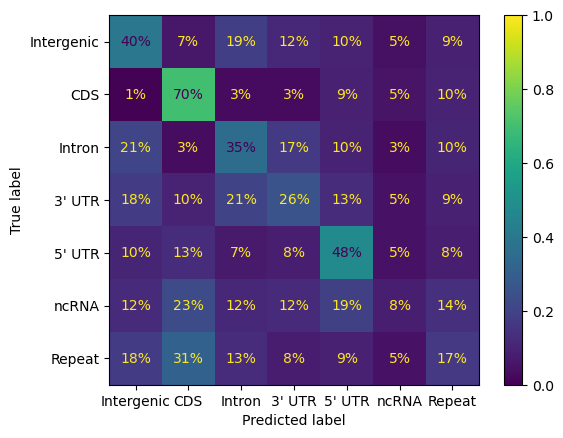

In [58]:
ConfusionMatrixDisplay.from_predictions(
    windows.Region, windows.pred_Region, normalize='true', labels=regions,
    values_format=".0%", im_kw=dict(vmin=0, vmax=1),
)

# Data Preprocessing

In [47]:
def tokenizer(seq):
  """
  Tokenizes nucleotides in a single DNA sequence.
  """
  dataset = ["acgt"]
  tokenizer = Tokenizer(models.BPE())
  tokenizer.normalizer = normalizers.Lowercase()
  trainer = BpeTrainer(vocab_size=1)

  tokenizer.train_from_iterator(dataset, trainer=trainer, length=len(dataset))
  tokenizer = PreTrainedTokenizerFast(tokenizer_object=tokenizer)
  return tokenizer.encode(seq)

def get_data(data):
  """
  Applies tokenizer to entire dataset and one-hot encodes labels.
  Returns GPN model input(X) and output labels(y) as (X, y).
  """
  X = torch.stack((data.seq.apply(tokenizer).apply(torch.tensor) + 1).tolist())
  y = F.one_hot(X, num_classes=5)
  return X, y

In [48]:
# Training dataset
X_train, y_train = get_data(train)
X_train, y_train

AttributeError: 'tokenizers.models.BPE' object has no attribute 'index'

In [ ]:
# Model training shape
# input = [1,2,1,2...]
# y = [[0,1,0,0,0], [0,0,1,0,0]...]

X_train.shape, y_train.shape

(torch.Size([500, 512]), torch.Size([500, 512, 5]))

# Building the Model

In [ ]:
class MaskLayer(nn.Module):
    def __init__(self, mask_percent=0.15):
        super().__init__()
        self.mask_percent = mask_percent

    def forward(self, x, training=False):
        if training:
          random_mask = torch.rand(x.shape) > self.mask_percent
          random_mask = random_mask.astype(x.dtype)
          mask_output = x * random_mask
          return mask_output
        return x

class TransposeLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = torch.transpose(x, 1, 2)
        return x

class ConvolutionLayer(nn.Module):
    def __init__(self, dilation, hidden_size=512):
        super().__init__()
        self.conv = nn.Sequential(
            TransposeLayer(),
            nn.Conv1d(
                in_channels=hidden_size,
                out_channels=hidden_size,
                padding="same",
                kernel_size=9,
                dilation=dilation
            ),
            TransposeLayer(),
            nn.GELU(),
            nn.LayerNorm(hidden_size),
        )

        self.ffn = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(),
            nn.LayerNorm(hidden_size),
        )

    def forward(self, x):
        x = x + self.conv(x)
        x = x + self.ffn(x)
        return x

class ConvolutionalBlocks(nn.Module):
    def __init__(self, num_layers=25):
        super().__init__()
        dilations = get_dilation_schedule()
        self.layers = nn.ModuleList(
            [ConvolutionLayer(dilation=dilations[i]) for i in range(num_layers)]
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

def get_dilation_schedule(max=32, base=2, cycle=6):
    return [min(max, base ** (i % cycle)) for i in range(25)]

In [ ]:
class GPN(nn.Module):
    def __init__(self, num_layers=25):
        super().__init__()
        self.mask = MaskLayer()
        self.embed = Embedding(5, 512)
        self.conv = ConvolutionalBlocks(num_layers=num_layers)
        self.nuc_logits = nn.Linear(512, 5)
        self.softmax = nn.Softmax()

    def forward(self, input, training=False):
        """
        input: (B, 512) a tensor with values in range [1,4]

        returns: output - (B, 512, 5) a tensor of prob.
        """
        x = input
        x = self.mask(x, training=training)
        x = self.embed(x)
        x = self.conv(x)
        x = self.nuc_logits(x)
        output = self.softmax(x)
        return output